# <center>Exam</center>

# <center>Neural Network and Deep Learning</center>

## Subject : Gesture Phase Recognition

The dataset is composed by features extracted from 7 videos with people gesticulating, aiming at studying Gesture Phase Segmentation. Each video is
represented by a processed file, which contains velocity and acceleration of hands and wrists.

Attribute Information : Processed file has 32 numeric attributes (double) and a class attribute (nominal). A feature vector with up to 50 numeric attributes can be generated with the two
files mentioned above. The objective of this database is to predict the phases.

## Import the modules

Here are all the modules we will use for our study.

In [510]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [511]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.experimental.preprocessing import Normalization
from keras.layers import Dropout
from keras.utils import to_categorical

## Import the data

We must extract all the data from the .csv files. I saw that the data was separated with comas (',') so it's the delimiter I used. I chose to extract all the data in string type to keep the values of the letters at the end, corresponding to the phases we want to predict.

In [513]:
raw_train_data = np.genfromtxt('phpYLeydd_train_9.csv', delimiter=',', dtype=np.str)
raw_test_data = np.genfromtxt('phpYLeydd_test.csv', delimiter=',', dtype=np.str)

## Split the data : train and test

In [514]:
train_data = pd.DataFrame(raw_train_data[:,:32], dtype=np.float)
train_data = pd.concat([train_data, pd.DataFrame(raw_train_data[:, 32], columns=['Phase'], dtype=np.str)], axis=1)
                      
print("Train data size : ", train_data.shape)

Train data size :  (7869, 33)


In [515]:
test_data = pd.DataFrame(raw_test_data[:,:32], dtype=np.float)
test_data = pd.concat([test_data, pd.DataFrame(raw_test_data[:, 32], columns=['Phase'], dtype=np.str)], axis=1)
                      
print("Test data size : ", test_data.shape)

Test data size :  (2004, 33)


In [516]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,Phase
0,0.004647,0.003085,-0.011122,-0.003645,-0.002298,-0.011911,0.004665,0.004779,-0.007793,-0.002502,0.003358,-0.000635,-0.000105,-0.000024,7.102200e-04,0.001868,-0.001853,-0.002112,4.195000e-05,-0.000086,0.000138,-0.000389,-0.002135,0.000050,0.012442,0.012667,0.010263,0.004235,0.000718,0.003374,0.000167,0.002170,'P'
1,0.000291,-0.000269,0.000009,0.008001,-0.002692,0.000571,0.000038,-0.000155,0.000015,-0.002124,0.002594,0.000792,-0.000013,0.000020,5.500000e-07,0.004822,-0.002238,-0.000018,-6.900000e-07,0.000013,-0.000002,0.000117,-0.000172,-0.000045,0.000396,0.008462,0.000160,0.003445,0.000024,0.005316,0.000013,0.000213,'D'
2,0.009894,-0.007128,0.000611,0.027808,-0.010683,-0.000391,0.007528,-0.005905,0.000699,0.023642,-0.000035,-0.000068,0.002204,-0.003183,-3.334400e-04,0.001323,-0.003844,0.000164,1.815480e-03,-0.002598,-0.000235,0.000859,-0.000315,0.000213,0.012210,0.029792,0.009593,0.023642,0.003885,0.004069,0.003178,0.000939,'P'
3,0.005704,-0.001695,0.003230,-0.003532,-0.000418,-0.007333,0.005785,-0.001633,0.005087,-0.002100,0.000257,-0.007409,0.000311,-0.000384,2.067210e-03,0.000847,-0.000280,-0.000822,6.854600e-04,-0.000275,0.001506,0.000640,-0.000449,0.000704,0.006771,0.008150,0.007875,0.007705,0.002125,0.001214,0.001677,0.001052,'D'
4,0.020035,-0.021255,0.000781,-0.005888,-0.023512,0.000617,0.006527,-0.024653,-0.000081,-0.004890,-0.025047,0.001205,-0.007674,0.003228,-2.403800e-04,0.007318,0.001591,-0.000148,-6.793280e-03,0.004564,-0.000095,0.007311,0.003091,0.000067,0.029219,0.024246,0.025502,0.025549,0.008329,0.007490,0.008185,0.007938,'R'


In [517]:
train_data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
count,7.869000e+03,7869.000000,7869.000000,7869.000000,7.869000e+03,7869.000000,7869.000000,7869.000000,7869.000000,7869.000000,7869.000000,7869.000000,7869.000000,7869.000000,7.869000e+03,7869.000000,7869.000000,7.869000e+03,7869.000000,7869.000000,7.869000e+03,7869.000000,7869.000000,7869.000000,7869.000000,7869.000000,7869.000000,7869.000000,7.869000e+03,7.869000e+03,7.869000e+03,7.869000e+03
mean,-3.588248e-05,0.000086,0.000084,0.000022,-6.686047e-07,-0.000003,-0.000026,0.000053,0.000083,0.000023,-0.000001,0.000024,-0.000004,0.000020,2.858818e-06,0.000002,-0.000007,1.359114e-06,0.000012,0.000021,1.497934e-06,-0.000001,-0.000007,0.000010,0.008572,0.011205,0.007129,0.009194,1.484619e-03,1.762960e-03,1.277970e-03,1.485941e-03
std,7.161049e-03,0.009931,0.006872,0.009114,1.293014e-02,0.007549,0.006043,0.008334,0.005856,0.007333,0.010736,0.006422,0.001636,0.001947,1.285657e-03,0.002120,0.002326,1.023453e-03,0.001374,0.001675,1.110900e-03,0.001652,0.001935,0.000955,0.011120,0.013478,0.009458,0.011214,2.432225e-03,2.800895e-03,2.072257e-03,2.274633e-03
min,-7.261983e-02,-0.079209,-0.084849,-0.088655,-1.072576e-01,-0.099232,-0.053584,-0.067566,-0.072807,-0.072441,-0.074737,-0.085708,-0.017342,-0.030157,-2.932498e-02,-0.045041,-0.033132,-1.731215e-02,-0.011691,-0.023505,-3.296556e-02,-0.039012,-0.026311,-0.012108,0.000019,0.000011,0.000012,0.000005,4.500000e-07,2.900000e-07,3.300000e-07,2.500000e-07
25%,-1.808130e-03,-0.001692,-0.000419,-0.002148,-2.864910e-03,-0.000607,-0.001507,-0.001356,-0.000377,-0.001790,-0.002174,-0.000537,-0.000235,-0.000232,-5.476000e-05,-0.000262,-0.000344,-7.915000e-05,-0.000195,-0.000199,-4.868000e-05,-0.000249,-0.000294,-0.000065,0.001193,0.001625,0.000982,0.001316,1.391100e-04,1.975300e-04,1.133300e-04,1.713400e-04
50%,-4.600000e-07,0.000032,-0.000004,-0.000007,-3.257000e-05,-0.000013,-0.000002,0.000012,-0.000007,0.000004,-0.000015,-0.000017,-0.000002,0.000002,4.500000e-07,0.000003,0.000004,7.600000e-07,0.000001,0.000003,4.700000e-07,0.000002,0.000001,0.000002,0.004197,0.006225,0.003464,0.005082,5.428200e-04,8.195700e-04,4.758600e-04,6.627900e-04
75%,1.662310e-03,0.002043,0.000374,0.002485,2.888190e-03,0.000509,0.001503,0.001657,0.000323,0.002032,0.002191,0.000455,0.000200,0.000255,6.442000e-05,0.000334,0.000411,9.277000e-05,0.000198,0.000213,6.061000e-05,0.000280,0.000304,0.000089,0.011744,0.015939,0.009612,0.012790,1.838470e-03,2.308650e-03,1.589330e-03,1.974110e-03
max,6.467823e-02,0.071600,0.091322,0.071854,1.320583e-01,0.072152,0.054369,0.055297,0.060706,0.055234,0.102922,0.081785,0.021828,0.030580,2.319812e-02,0.028694,0.080486,1.307033e-02,0.016234,0.021404,2.301619e-02,0.015387,0.062295,0.010531,0.106504,0.154135,0.077625,0.124277,4.262203e-02,9.232396e-02,3.933604e-02,7.354483e-02


## Data visualization

In the following graph, we can see the repartition of the different phases in the training set.
 * D (rest position, from portuguese ”descanso”)
 * P (preparation)
 * S (stroke)
 * H (hold)
 * R (retraction)


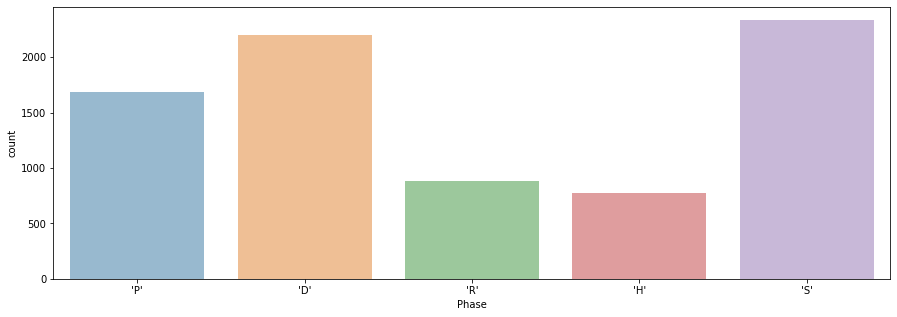

In [518]:
fig = plt.figure(figsize=(15,5))
ax = sns.countplot(x='Phase',data=train_data,alpha=0.5)

We will replace the letters by numbers in the train and test datasets to create the model in a few steps :

In [519]:
train_data = train_data.replace('D', 0, regex=True)
train_data = train_data.replace('P', 1, regex=True)
train_data = train_data.replace('S', 2, regex=True)
train_data = train_data.replace('H', 3, regex=True)
train_data = train_data.replace('R', 4, regex=True)

In [520]:
test_data = test_data.replace('D', 0, regex=True)
test_data = test_data.replace('P', 1, regex=True)
test_data = test_data.replace('S', 2, regex=True)
test_data = test_data.replace('H', 3, regex=True)
test_data = test_data.replace('R', 4, regex=True)

In [521]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,Phase
0,0.004647,0.003085,-0.011122,-0.003645,-0.002298,-0.011911,0.004665,0.004779,-0.007793,-0.002502,0.003358,-0.000635,-0.000105,-0.000024,7.102200e-04,0.001868,-0.001853,-0.002112,4.195000e-05,-0.000086,0.000138,-0.000389,-0.002135,0.000050,0.012442,0.012667,0.010263,0.004235,0.000718,0.003374,0.000167,0.002170,1
1,0.000291,-0.000269,0.000009,0.008001,-0.002692,0.000571,0.000038,-0.000155,0.000015,-0.002124,0.002594,0.000792,-0.000013,0.000020,5.500000e-07,0.004822,-0.002238,-0.000018,-6.900000e-07,0.000013,-0.000002,0.000117,-0.000172,-0.000045,0.000396,0.008462,0.000160,0.003445,0.000024,0.005316,0.000013,0.000213,0
2,0.009894,-0.007128,0.000611,0.027808,-0.010683,-0.000391,0.007528,-0.005905,0.000699,0.023642,-0.000035,-0.000068,0.002204,-0.003183,-3.334400e-04,0.001323,-0.003844,0.000164,1.815480e-03,-0.002598,-0.000235,0.000859,-0.000315,0.000213,0.012210,0.029792,0.009593,0.023642,0.003885,0.004069,0.003178,0.000939,1
3,0.005704,-0.001695,0.003230,-0.003532,-0.000418,-0.007333,0.005785,-0.001633,0.005087,-0.002100,0.000257,-0.007409,0.000311,-0.000384,2.067210e-03,0.000847,-0.000280,-0.000822,6.854600e-04,-0.000275,0.001506,0.000640,-0.000449,0.000704,0.006771,0.008150,0.007875,0.007705,0.002125,0.001214,0.001677,0.001052,0
4,0.020035,-0.021255,0.000781,-0.005888,-0.023512,0.000617,0.006527,-0.024653,-0.000081,-0.004890,-0.025047,0.001205,-0.007674,0.003228,-2.403800e-04,0.007318,0.001591,-0.000148,-6.793280e-03,0.004564,-0.000095,0.007311,0.003091,0.000067,0.029219,0.024246,0.025502,0.025549,0.008329,0.007490,0.008185,0.007938,4


Then we split the data into a train and a test variable for both dataframes :

In [522]:
X_train, Y_train = train_data.iloc[:, :-1], train_data.iloc[:, -1]
X_test, Y_test = test_data.iloc[:, :-1], test_data.iloc[: , -1]

In [523]:
Y_train -= 1
Y_test -= 1

Y_train = to_categorical(Y_train, num_classes=32)
Y_test = to_categorical(Y_test, num_classes=32)

In [524]:
X = np.concatenate((X_train, X_test))

## Creating the model

Now we create the model and add parameters. I tried a lot of parameters manually to find the best one without making overfitting.

In [525]:
normalizer = Normalization()
normalizer.adapt(X)

In [526]:
model = Sequential([
    normalizer,
    Dense(512, activation='sigmoid', input_shape=(7869,)),
    Dropout(0.2),
    Dense(64, activation='sigmoid'),
    Dropout(0.2),
    Dense(128, activation='sigmoid'),
    Dropout(0.2),
    Dense(32, activation='softmax'),
])

In [527]:
print(model.summary())

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 32)                65        
_________________________________________________________________
dense_136 (Dense)            (None, 512)               16896     
_________________________________________________________________
dropout_89 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_137 (Dense)            (None, 64)                32832     
_________________________________________________________________
dropout_90 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_138 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_91 (Dropout)         (None, 128)             

In [528]:
model.compile(
    optimizer=RMSprop(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [529]:
history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    validation_split=0.2
)

Epoch 1/100
197/197 [==============================] - 2s 4ms/step - loss: 1.7735 - accuracy: 0.2835 - val_loss: 1.3381 - val_accuracy: 0.4530
Epoch 2/100
197/197 [==============================] - 1s 3ms/step - loss: 1.3877 - accuracy: 0.4178 - val_loss: 1.3082 - val_accuracy: 0.4746
Epoch 3/100
197/197 [==============================] - 1s 3ms/step - loss: 1.3292 - accuracy: 0.4486 - val_loss: 1.2809 - val_accuracy: 0.4784
Epoch 4/100
197/197 [==============================] - 1s 3ms/step - loss: 1.3062 - accuracy: 0.4739 - val_loss: 1.2754 - val_accuracy: 0.4784
Epoch 5/100
197/197 [==============================] - 1s 3ms/step - loss: 1.2876 - accuracy: 0.4802 - val_loss: 1.2468 - val_accuracy: 0.4822
Epoch 6/100
197/197 [==============================] - 1s 4ms/step - loss: 1.2817 - accuracy: 0.4821 - val_loss: 1.2878 - val_accuracy: 0.4740
Epoch 7/100
197/197 [==============================] - 1s 3ms/step - loss: 1.2678 - accuracy: 0.4958 - val_loss: 1.2360 - val_accuracy: 0.4930

In [530]:
probs = model.predict(X_test)
predicted_labels = [np.argmax(p) for p in probs]

In [531]:
test_loss, test_acc = model.evaluate(X_train, Y_train, verbose=0)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Test accuracy: 0.6223154067993164
Test loss: 0.9676825404167175


## Data visualisation

We can use graphs to evaluate our model. The will take a look at the evolution of accuracy in the first graph and the evolution of loss in the second one, according to the evolution of epochs.

We can see first that there is not too much overfit, so the parameters are not bad. When we add epochs, the model improves, but I decided to not go above 100 iterations because the algorithm would have been much eavier and less performant because of the long running time.

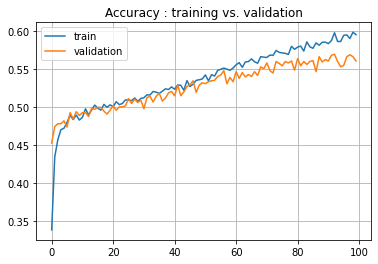

In [538]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(range(len(accuracy)), accuracy, label='train')
plt.plot(range(len(val_accuracy)), val_accuracy, label='validation')
plt.title("Accuracy : training vs. validation")
plt.legend()
plt.grid()
plt.show()

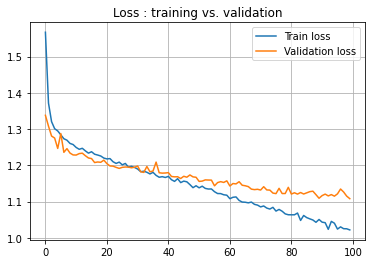

In [537]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(len(loss)), loss, label='Train loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation loss')
plt.title("Loss : training vs. validation")
plt.legend()
plt.grid()
plt.show()

## Improvements

I think I could improve the results by comparing different models or trying to make a search of the best parameters, but I think I had not the time because this process is very long and every time I did this, the improvement was not huge. I think it was not worth it.